In [2]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(stats)
library(ggpubr)
library(dunn.test)

In [3]:
#5krare
cadaver = readRDS("/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/all_cohorts_cadaver_5krare.rds")

#otu.5k = data.frame(otu_table(cadaver))
#meta.5k = data.frame(sample_data(cadaver))


In [4]:
#Read in/out to format for ANCOM
otu.5k = read.csv("/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/update_march2019/CSVfiles/5k_otu.csv")
meta.5k = read.csv("/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/update_march2019/CSVfiles/5k_meta.csv")

#### ANCOM with Covariates

##### Finland vs Other

In [5]:
finland = meta.5k %>%
mutate(Single_Loc = Location)

finland$Single_Loc = as.character(finland$Single_Loc)
finland$Single_Loc[which(finland$Location != "Finland")] = "Other"
finland$Single_Loc = as.factor(finland$Single_Loc)
head(finland$Single_Loc)

[1] Finland Finland Other   Other   Other   Other  
Levels: Finland Other

In [11]:
#RUN ANCOM

comparison_test=ANCOM.main(OTUdat=otu.5k,
                           Vardat=finland,
                           adjusted=TRUE,
                           repeated=F,
                           main.var="Single_Loc",
                           #adj.formula=FALSE,
                           adj.formula="Organ", #covariates
                           repeat.var=NULL,
                           longitudinal=FALSE,
                           random.formula=NULL,
                           multcorr=2, #2 corresponds to BH FDR correction
                           sig=0.05,
                           prev.cut=0.90)

finland.all.ancom = comparison_test$W.taxa
write.csv(finland.all.ancom, "/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/update_march2019/ANCOM/location.finland.all.ancom.csv")

##### Italy vs Other

In [12]:
italy = meta.5k %>%
mutate(Single_Loc = Location)

italy$Single_Loc = as.character(italy$Single_Loc)
italy$Single_Loc[which(italy$Location != "Italy")] = "Other"
italy$Single_Loc = as.factor(italy$Single_Loc)
head(italy$Single_Loc)

[1] Other Other Italy Italy Italy Italy
Levels: Italy Other

In [13]:
#RUN ANCOM

comparison_test=ANCOM.main(OTUdat=otu.5k,
                           Vardat=italy,
                           adjusted=TRUE,
                           repeated=F,
                           main.var="Single_Loc",
                           adj.formula=FALSE,
                           #adj.formula="Sex+Age+Ethnicity+PMI+bmi_category+Organ", #covariates
                           repeat.var=NULL,
                           longitudinal=FALSE,
                           random.formula=NULL,
                           multcorr=2, #2 corresponds to BH FDR correction
                           sig=0.05,
                           prev.cut=0.90)

italy.all.ancom = comparison_test$W.taxa
write.csv(italy.all.ancom, "/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/update_march2019/ANCOM/location.italy.all.ancom.csv")

##### USA vs Other

In [14]:
USA = meta.5k %>%
mutate(Single_Loc = Location)

USA$Single_Loc = as.character(USA$Single_Loc)
USA$Single_Loc[which(USA$Location != "USA")] = "Other"
USA$Single_Loc = as.factor(USA$Single_Loc)
head(USA$Single_Loc)

[1] Other Other Other Other Other Other
Levels: Other USA

In [15]:
#RUN ANCOM

comparison_test=ANCOM.main(OTUdat=otu.5k,
                           Vardat=USA,
                           adjusted=TRUE,
                           repeated=F,
                           main.var="Single_Loc",
                           #adj.formula=FALSE,
                           adj.formula="Sex+Age+Ethnicity+PMI+bmi_category+Organ", #covariates
                           repeat.var=NULL,
                           longitudinal=FALSE,
                           random.formula=NULL,
                           multcorr=2, #2 corresponds to BH FDR correction
                           sig=0.05,
                           prev.cut=0.90)

USA.all.ancom = comparison_test$W.taxa
write.csv(USA.all.ancom, "/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/update_march2019/ANCOM/location.USA.all.ancom.csv")

### Run DeSEQ to get log2fold change values for ancom-identified OTUs

In [19]:
library(DESeq2)

In [16]:
#Read metadata in/out to convert to mapfile for new ps object (retaining Single_MOD column)
#write.csv(finland, "/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/update_march2019/DESEQ/finland.meta.csv")
#write.csv(italy, "/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/update_march2019/DESEQ/italy.meta.csv")
#write.csv(USA, "/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/update_march2019/DESEQ/USA.meta.csv")

finland.map = import_qiime_sample_data("/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/update_march2019/DESEQ/finland.meta.txt")
italy.map = import_qiime_sample_data("/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/update_march2019/DESEQ/italy.meta.txt")
USA.map = import_qiime_sample_data("/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/update_march2019/DESEQ/USA.meta.txt")

#create new ps objects 

tree = phy_tree(cadaver)
otu = otu_table(cadaver)
tax = tax_table(cadaver)

finland.ps = merge_phyloseq(finland.map, tree, otu, tax)
italy.ps = merge_phyloseq(italy.map, tree, otu, tax)
usa.ps = merge_phyloseq(USA.map, tree, otu, tax)


In [17]:
#convert ps to deseq object

finland_dds = phyloseq_to_deseq2(finland.ps, ~Single_Loc)
italy_dds = phyloseq_to_deseq2(italy.ps, ~Single_Loc)
usa_dds = phyloseq_to_deseq2(usa.ps, ~Single_Loc)

Loading required namespace: DESeq2
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode


In [20]:
#Run DESeq - finland 5k rarefied

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans = apply(DESeq2::counts(finland_dds), 1, gm_mean)


finland_dds = estimateSizeFactors(finland_dds, geoMeans = geoMeans)
finland_dds = estimateDispersions(finland_dds)
abund = getVarianceStabilizedData(finland_dds)

finland_dds = DESeq(finland_dds, test="Wald", fitType="parametric")

res = results(finland_dds)
res.tax = cbind(as(res, "data.frame"), as(tax_table(finland.ps)[rownames(res), ], "matrix"))

#don't ned significance values, just want log2fold change
#alpha = 0.05
#sigtab = res[which(res$padj < alpha), ]
#sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(finland_pc)[rownames(sigtab), ], "matrix"))

write.csv(res.tax, file="/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/update_march2019/DESEQ/finland.deseq.log2fold.csv")


gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 437 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [21]:
#Run DESeq - Italy 5k rarefied

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans = apply(DESeq2::counts(italy_dds), 1, gm_mean)


italy_dds = estimateSizeFactors(italy_dds, geoMeans = geoMeans)
italy_dds = estimateDispersions(italy_dds)
abund = getVarianceStabilizedData(italy_dds)

italy_dds = DESeq(italy_dds, test="Wald", fitType="parametric")

res = results(italy_dds)
res.tax = cbind(as(res, "data.frame"), as(tax_table(italy.ps)[rownames(res), ], "matrix"))

#don't ned significance values, just want log2fold change
#alpha = 0.05
#sigtab = res[which(res$padj < alpha), ]
#sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(italy_pc)[rownames(sigtab), ], "matrix"))

write.csv(res.tax, file="/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/update_march2019/DESEQ/italy.deseq.log2fold.csv")


gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 487 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [22]:
#Run DESeq - USA 5k rarefied

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans = apply(DESeq2::counts(usa_dds), 1, gm_mean)


usa_dds = estimateSizeFactors(usa_dds, geoMeans = geoMeans)
usa_dds = estimateDispersions(usa_dds)
abund = getVarianceStabilizedData(usa_dds)

usa_dds = DESeq(usa_dds, test="Wald", fitType="parametric")

res = results(usa_dds)
res.tax = cbind(as(res, "data.frame"), as(tax_table(usa.ps)[rownames(res), ], "matrix"))

#don't ned significance values, just want log2fold change
#alpha = 0.05
#sigtab = res[which(res$padj < alpha), ]
#sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(usa_pc)[rownames(sigtab), ], "matrix"))

write.csv(res.tax, file="/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/update_march2019/DESEQ/usa.deseq.log2fold.csv")


gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 481 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


#### Plot log2Fold change values of ANCOM results

In [18]:
ancom_0.70.loc = read.csv("/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/update_march2019/ANCOM/Country.allorgan.ancom_0.70.tax.summary.csv")


png 
  2

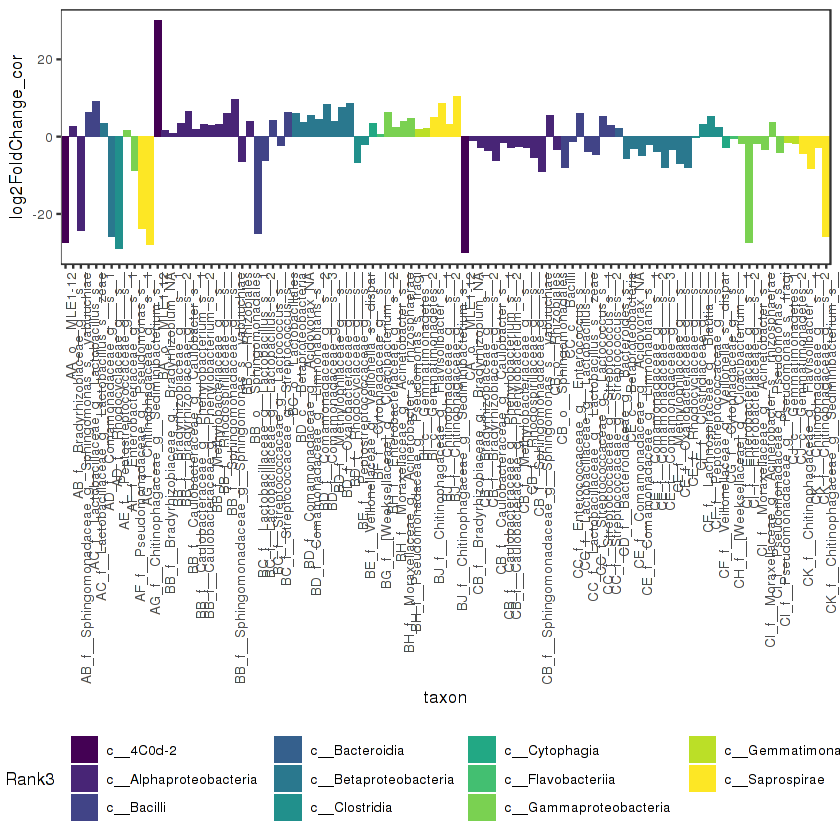

In [19]:
library(viridis)
p = ggplot(ancom_0.70.loc, aes(x = taxon, y = log2FoldChange_cor, fill=Rank3)) + geom_bar(stat="identity")

p = p + scale_fill_viridis(option="viridis", discrete=TRUE, direction=1)

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Calibri"),
                           #legend.key = element_blank(),
                           axis.text.x = element_text(angle = 90, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p

#p2 = p + facet_wrap(~MOD)
#p2

png('Locality_ANCOM_log2foldchange_0.70.png', width=10, height=10, units='in', res=300)
plot(p)
dev.off()

##### ANCOM: raw code from Knight Lab

In [7]:
library(exactRankTests)
library(nlme)
library(ggplot2)

ancom.W = function(otu_data,var_data,
                   adjusted,repeated,
                   main.var,adj.formula,
                   repeat.var,long,rand.formula,
                   multcorr,sig){
  
  n_otu=dim(otu_data)[2]-1
  
  otu_ids=colnames(otu_data)[-1]
  
  if(repeated==F){
    data_comp=data.frame(merge(otu_data,var_data,by="Sample.ID",all.y=T),row.names=NULL)
    #data_comp=data.frame(merge(otu_data,var_data[,c("Sample.ID",main.var)],by="Sample.ID",all.y=T),row.names=NULL)
  }else if(repeated==T){
    data_comp=data.frame(merge(otu_data,var_data,by="Sample.ID"),row.names=NULL)
   # data_comp=data.frame(merge(otu_data,var_data[,c("Sample.ID",main.var,repeat.var)],by="Sample.ID"),row.names=NULL)
  }
  
  base.formula = paste0("lr ~ ",main.var)
  if(repeated==T){
    repeat.formula = paste0(base.formula," | ", repeat.var)
  }
  if(adjusted==T){
    adjusted.formula = paste0(base.formula," + ", adj.formula)
  }
  
  if( adjusted == F & repeated == F ){
    fformula  <- formula(base.formula)
  } else if( adjusted == F & repeated == T & long == T ){
    fformula  <- formula(base.formula)   
  }else if( adjusted == F & repeated == T & long == F ){
    fformula  <- formula(repeat.formula)   
  }else if( adjusted == T & repeated == F  ){
    fformula  <- formula(adjusted.formula)   
  }else if( adjusted == T & repeated == T  ){
    fformula  <- formula(adjusted.formula)   
  }else{
    stop("Problem with data. Dataset should contain OTU abundances, groups, 
         and optionally an ID for repeated measures.")
  }
  
  
  
    if( repeated==FALSE & adjusted == FALSE){
       if( length(unique(data_comp[,which(colnames(data_comp)==main.var)]))==2 ){
          tfun <- exactRankTests::wilcox.exact
       } else{
          tfun <- stats::kruskal.test
    }
    }else if( repeated==FALSE & adjusted == TRUE){
      tfun <- stats::aov
    }else if( repeated== TRUE & adjusted == FALSE & long == FALSE){
      tfun <- stats::friedman.test
    }else if( repeated== TRUE & adjusted == FALSE & long == TRUE){
      tfun <- nlme::lme
    }else if( repeated== TRUE & adjusted == TRUE){
      tfun <- nlme::lme
    }
  
  logratio.mat <- matrix(NA, nrow=n_otu, ncol=n_otu)
  for(ii in 1:(n_otu-1)){
    for(jj in (ii+1):n_otu){
      data.pair <- data_comp[,which(colnames(data_comp)%in%otu_ids[c(ii,jj)])]
      lr <- log((1+as.numeric(data.pair[,1]))/(1+as.numeric(data.pair[,2])))
      
      lr_dat <- data.frame( lr=lr, data_comp,row.names=NULL )
      
      if(adjusted==FALSE&repeated==FALSE){  ## Wilcox, Kruskal Wallis
        logratio.mat[ii,jj] <- tfun( formula=fformula, data = lr_dat)$p.value
      }else if(adjusted==FALSE&repeated==TRUE&long==FALSE){ ## Friedman's 
        logratio.mat[ii,jj] <- tfun( formula=fformula, data = lr_dat)$p.value
      }else if(adjusted==TRUE&repeated==FALSE){ ## ANOVA
        model=tfun(formula=fformula, data = lr_dat,na.action=na.omit)   
        picker=which(gsub(" ","",row.names(summary(model)[[1]]))==main.var)  
        logratio.mat[ii,jj] <- summary(model)[[1]][["Pr(>F)"]][picker]
      }else if(repeated==TRUE&long==TRUE){ ## GEE
        model=tfun(fixed=fformula,data = lr_dat,
                   random = formula(rand.formula),
                   correlation=corAR1(),
                   na.action=na.omit)   
        picker=which(gsub(" ","",row.names(anova(model)))==main.var)
        logratio.mat[ii,jj] <- anova(model)[["p-value"]][picker]
      }
      
    }
  } 
  
  ind <- lower.tri(logratio.mat)
  logratio.mat[ind] <- t(logratio.mat)[ind]
  
  
  logratio.mat[which(is.finite(logratio.mat)==FALSE)] <- 1
  
  mc.pval <- t(apply(logratio.mat,1,function(x){
    s <- p.adjust(x, method = "BH")
    return(s)
  }))
  
  a <- logratio.mat[upper.tri(logratio.mat,diag=FALSE)==TRUE]
  
  b <- matrix(0,ncol=n_otu,nrow=n_otu)
  b[upper.tri(b)==T] <- p.adjust(a, method = "BH")
  diag(b)  <- NA
  ind.1    <- lower.tri(b)
  b[ind.1] <- t(b)[ind.1]
  
  #########################################
  ### Code to extract surrogate p-value
  surr.pval <- apply(mc.pval,1,function(x){
    s0=quantile(x[which(as.numeric(as.character(x))<sig)],0.95)
    # s0=max(x[which(as.numeric(as.character(x))<alpha)])
    return(s0)
  })
  #########################################
  ### Conservative
  if(multcorr==1){
    W <- apply(b,1,function(x){
      subp <- length(which(x<sig))
    })
    ### Moderate
  } else if(multcorr==2){
    W <- apply(mc.pval,1,function(x){
      subp <- length(which(x<sig))
    })
    ### No correction
  } else if(multcorr==3){
    W <- apply(logratio.mat,1,function(x){
      subp <- length(which(x<sig))
    })
  }
  
  return(W)
  }



ANCOM.main = function(OTUdat,Vardat,
                      adjusted,repeated,
                      main.var,adj.formula,
                      repeat.var,longitudinal,
                      random.formula,
                      multcorr,sig,
                      prev.cut){
  
  p.zeroes=apply(OTUdat[,-1],2,function(x){
    s=length(which(x==0))/length(x)
  })
  
  zeroes.dist=data.frame(colnames(OTUdat)[-1],p.zeroes,row.names=NULL)
  colnames(zeroes.dist)=c("Taxon","Proportion_zero")
  
  zero.plot = ggplot(zeroes.dist, aes(x=Proportion_zero)) + 
              geom_histogram(binwidth=0.1,colour="black",fill="white") + 
              xlab("Proportion of zeroes") + ylab("Number of taxa") +
              theme_bw()
  
  #print(zero.plot)
  
  OTUdat.thinned=OTUdat
  OTUdat.thinned=OTUdat.thinned[,c(1,1+which(p.zeroes<prev.cut))]
  
  otu.names=colnames(OTUdat.thinned)[-1]
  
  W.detected   <- ancom.W(OTUdat.thinned,Vardat,
                          adjusted,repeated,
                          main.var,adj.formula,
                          repeat.var,longitudinal,random.formula,
                          multcorr,sig)
  
  W_stat       <- W.detected
  
  
  ### Bubble plot
  
  W_frame = data.frame(otu.names,W_stat,row.names=NULL)
  W_frame = W_frame[order(-W_frame$W_stat),]
  
  W_frame$detected_0.9=rep(FALSE,dim(W_frame)[1])
  W_frame$detected_0.8=rep(FALSE,dim(W_frame)[1])
  W_frame$detected_0.7=rep(FALSE,dim(W_frame)[1])
  W_frame$detected_0.6=rep(FALSE,dim(W_frame)[1])
  
  W_frame$detected_0.9[which(W_frame$W_stat>0.9*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  W_frame$detected_0.8[which(W_frame$W_stat>0.8*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  W_frame$detected_0.7[which(W_frame$W_stat>0.7*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  W_frame$detected_0.6[which(W_frame$W_stat>0.6*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  
  final_results=list(W_frame,zero.plot)
  names(final_results)=c("W.taxa","PLot.zeroes")
  return(final_results)
    }

 Package ‘exactRankTests’ is no longer under development.
 Please consider using package ‘coin’ instead.


Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

